# Convolutional Neural Networks
This notebook will guide you through the use of the `keras` package to train convolutional neural networks for handwritten digits classification. You are going to use the `mnist` dataset from LeCun et al. 1998.

## Loading the packages

In [11]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as pl

from keras.datasets import mnist
from keras.models import Model
from keras.layers.core import Dense, Dropout, Flatten
from keras.optimizers import RMSprop
from keras.utils import np_utils
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Input
from sklearn import metrics as me
from scipy import stats

%matplotlib inline

First, create some useful functions

In [3]:
def build_grid_of_images(array):
    assert len(array.shape) == 3
    dim_0 = np.sqrt(array.shape[0])
    assert dim_0.is_integer()
    
    temp_out = np.reshape(array, (dim_0, dim_0, array.shape[1], array.shape[2]))
    temp_out = np.rollaxis(temp_out, 1, 3)
    return np.reshape(temp_out, (dim_0*array.shape[1], dim_0*array.shape[2]))

#a = np.array(np.arange(36))
#print a

#b = np.reshape(a, (4,3,3))
#print b[0,:,:]
#print b[1,:,:]

#c = build_grid_of_images(b)
#print c

def plot_conv_layer_output(temp_out, title):
    temp_to_plot = build_grid_of_images(temp_out)
    pl.imshow(temp_to_plot, interpolation='nearest', cmap=pl.get_cmap('Greys'))
    ax = pl.gca()
    ax.set_xticks(np.arange(-0.5, temp_to_plot.shape[0]+0.5, temp_out.shape[1]))    
    ax.set_yticks(np.arange(-0.5, temp_to_plot.shape[0]+0.5, temp_out.shape[2]))
    pl.grid()
    pl.tick_params(axis='both', which='both', bottom='off', top='off', left='off', right='off', labelbottom='off', labelleft='off')
    pl.title(title)

def plot_dense_layer_output(temp_out, title):
    pl.bar(np.arange(temp_out.shape[1])-0.4, temp_out[0,:])
    pl.xlim(-0.5, temp_out.shape[1])
    pl.grid()
    pl.title(title)

Load the `mnist` dataset and normalize in the range [0, 1]

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

n_train, height, width = X_train.shape
n_test, _, _ = X_test.shape

X_train = X_train.reshape(n_train, height, width, 1).astype('float32')
X_test = X_test.reshape(n_test, height, width, 1).astype('float32')

X_train /= 255.0
X_test /= 255.0

n_classes = 10

print(n_train, 'train samples')
print(n_test, 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

60000 train samples
10000 test samples


Create the CNN and show its architecture

In [7]:
neurons = [i for i in range(5,55,5)]
score_n = []
accuracy_n = []
for n in neurons:
    l0 = Input(shape=(height, width, 1), name='l0')

    l1 = Convolution2D(9, 5, 5, border_mode='same', activation='relu', name='l1')(l0)
    l1_mp = MaxPooling2D(pool_size=(2, 2), name='l1_mp')(l1)

    l2 = Convolution2D(9, 5, 5, border_mode='same', activation='relu', name='l2')(l1_mp)
    l2_mp = MaxPooling2D(pool_size=(2, 2), name='l2_mp')(l2)

    l3 = Convolution2D(16, 3, 3, border_mode='same', activation='relu', name='l3')(l2_mp)
    l3_mp = MaxPooling2D(pool_size=(2, 2), name='l3_mp')(l3)

    flat = Flatten(name='flat')(l3_mp)

    l4 = Dense(n, activation='relu', name='l4')(flat)

    l5 = Dense(n_classes, activation='softmax', name='l5')(l4)

    model = Model(input=l0, output=l5)
    model.summary()
    batch_size = 128
    n_epoch = 10

    model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])
    history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epoch, verbose=1, validation_data=(X_test, Y_test))

    score = model.evaluate(X_test, Y_test, verbose=0)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])
    score_n.append(score[0])
    accuracy_n.append(score[1])

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(9, (5, 5), activation="relu", name="l1", padding="same")`
  import sys
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(9, (5, 5), activation="relu", name="l2", padding="same")`
  # Remove the CWD from sys.path while we load stuff.
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), activation="relu", name="l3", padding="same")`
  del sys.path[0]
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("l0..., outputs=Tensor("l5...)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
l0 (InputLayer)              (None, 28, 28, 1)         0         
_________________________________________________________________
l1 (Conv2D)                  (None, 28, 28, 9)         234       
_________________________________________________________________
l1_mp (MaxPooling2D)         (None, 14, 14, 9)         0         
_________________________________________________________________
l2 (Conv2D)                  (None, 14, 14, 9)         2034      
_________________________________________________________________
l2_mp (MaxPooling2D)         (None, 7, 7, 9)           0         
_________________________________________________________________
l3 (Conv2D)                  (None, 7, 7, 16)          1312      
_________________________________________________________________
l3_mp (MaxPooling2D)         (None, 3, 3, 16)          0         
__________

Epoch 3/10
60000/60000 [==============================] - 2s 34us/step - loss: 0.1210 - acc: 0.9626 - val_loss: 0.0836 - val_acc: 0.9729
Epoch 4/10
60000/60000 [==============================] - 2s 34us/step - loss: 0.0946 - acc: 0.9708 - val_loss: 0.0806 - val_acc: 0.9750
Epoch 5/10
60000/60000 [==============================] - 2s 35us/step - loss: 0.0788 - acc: 0.9761 - val_loss: 0.0712 - val_acc: 0.9770
Epoch 6/10
60000/60000 [==============================] - 2s 34us/step - loss: 0.0676 - acc: 0.9796 - val_loss: 0.0634 - val_acc: 0.9793
Epoch 7/10
60000/60000 [==============================] - 2s 35us/step - loss: 0.0602 - acc: 0.9814 - val_loss: 0.0627 - val_acc: 0.9808
Epoch 8/10
60000/60000 [==============================] - 2s 34us/step - loss: 0.0540 - acc: 0.9828 - val_loss: 0.0566 - val_acc: 0.9810
Epoch 9/10
60000/60000 [==============================] - 2s 35us/step - loss: 0.0490 - acc: 0.9847 - val_loss: 0.0531 - val_acc: 0.9821
Epoch 10/10
60000/60000 [================

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 3s 43us/step - loss: 0.4592 - acc: 0.8596 - val_loss: 0.1358 - val_acc: 0.9593
Epoch 2/10
60000/60000 [==============================] - 2s 35us/step - loss: 0.1331 - acc: 0.9593 - val_loss: 0.1024 - val_acc: 0.9699
Epoch 3/10
60000/60000 [==============================] - 2s 35us/step - loss: 0.0964 - acc: 0.9706 - val_loss: 0.0824 - val_acc: 0.9765
Epoch 4/10
60000/60000 [==============================] - 2s 35us/step - loss: 0.0774 - acc: 0.9765 - val_loss: 0.0780 - val_acc: 0.9771
Epoch 5/10
60000/60000 [==============================] - 2s 35us/step - loss: 0.0673 - acc: 0.9790 - val_loss: 0.0678 - val_acc: 0.9803
Epoch 6/10
60000/60000 [==============================] - 2s 35us/step - loss: 0.0578 - acc: 0.9823 - val_loss: 0.0773 - val_acc: 0.9760
Epoch 7/10
60000/60000 [==============================] - 2s 35us/step - loss: 0.0521 - acc: 0.9839 - val_loss: 0.0517 - val_acc

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 3s 45us/step - loss: 0.5242 - acc: 0.8391 - val_loss: 0.1708 - val_acc: 0.9476
Epoch 2/10
60000/60000 [==============================] - 2s 37us/step - loss: 0.1421 - acc: 0.9569 - val_loss: 0.1078 - val_acc: 0.9651
Epoch 3/10
60000/60000 [==============================] - 2s 36us/step - loss: 0.0945 - acc: 0.9698 - val_loss: 0.0879 - val_acc: 0.9715
Epoch 4/10
60000/60000 [==============================] - 2s 35us/step - loss: 0.0744 - acc: 0.9772 - val_loss: 0.0532 - val_acc: 0.9825
Epoch 5/10
60000/60000 [==============================] - 2s 36us/step - loss: 0.0606 - acc: 0.9812 - val_loss: 0.0591 - val_acc: 0.9812
Epoch 6/10
60000/60000 [==============================] - 2s 37us/step - loss: 0.0522 - acc: 0.9839 - val_loss: 0.0749 - val_acc: 0.9782
Epoch 7/10
60000/60000 [==============================] - 2s 37us/step - loss: 0.0466 - acc: 0.9854 - val_loss: 0.0478 - val_acc

Define some constants and train de CNN

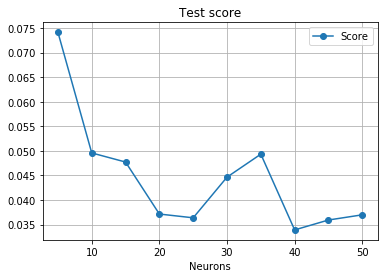

In [25]:
df = pd.DataFrame({
    'Neurons':neurons,
    'Score':score_n,
    'Accuracy':accuracy_n,
})

#ax = pl.gca()

df.plot(kind='line',x='Neurons',y='Score',style='-o')
pl.title('Test score')
#df.plot(kind='line',x='Neurons',y='Accuracy', color='red', ax=ax)
pl.grid()
pl.show()

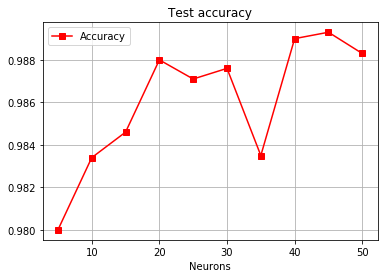

In [27]:
df.plot(kind='line',x='Neurons',y='Accuracy', color='red',style='-s')
pl.title('Test accuracy')
pl.grid()
pl.show()